In [28]:
import os
import sys

#sys.path.append('../')

import ot
import torch  # noqa: E402
import pickle  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import seaborn as sns
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [29]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [30]:
dataset.shape

(2860, 18)

In [31]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [32]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [33]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [34]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [39]:
n_samples = 1300
batch_size = 260
n_components = 3

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)

In [49]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

dim_reduction = 6
K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample_with_dim_reduction(Xt[i:i+dim_reduction, :])
    i += dim_reduction

OGMM.generate_list()

[[tensor(2.2236e-06),
  tensor(4.0616),
  tensor([ 2.3172e-01, -2.7162e-02,  2.2678e-03, -5.7817e-05,  3.4690e-03,
           9.3133e-04]),
  tensor([[ 6.3347e-03, -9.8129e-04,  1.8382e-04, -1.8654e-04, -1.8556e-05,
           -2.1346e-04],
          [-9.8129e-04,  3.8167e-03, -1.5231e-04,  6.8781e-05,  1.0423e-05,
            9.3989e-05],
          [ 1.8382e-04, -1.5231e-04,  3.5225e-03,  1.4529e-05, -2.0872e-05,
           -2.6366e-05],
          [-1.8654e-04,  6.8781e-05,  1.4529e-05,  3.4323e-03, -8.3657e-06,
            3.2693e-05],
          [-1.8556e-05,  1.0423e-05, -2.0872e-05, -8.3657e-06,  3.3931e-03,
            7.8095e-08],
          [-2.1346e-04,  9.3989e-05, -2.6366e-05,  3.2693e-05,  7.8095e-08,
            3.4163e-03]])],
 [tensor(0.0008),
  tensor(8.9177),
  tensor([-0.4634,  0.2255, -0.0209,  0.0071,  0.0172,  0.0059]),
  tensor([[ 5.3263e-02, -5.6827e-02, -3.0473e-02,  1.9341e-03,  6.6006e-03,
            1.4799e-03],
          [-5.6827e-02,  1.1343e-01,  3.4682e-02

Test to determine the best K_max

In [45]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample_with_dim_reduction(X_train_target_t[i:i+dim_reduction, :])
        i += dim_reduction

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood_with_dim_reduction(X_test_target_t))

[[tensor(8.0335e-06), tensor(10.4135), tensor([ 0.1088,  0.0569, -0.0835,  0.1130, -0.1406, -0.0058]), tensor([[ 0.0247,  0.0068,  0.0035, -0.0013,  0.0091, -0.0006],
        [ 0.0068,  0.0088, -0.0028, -0.0017,  0.0063,  0.0025],
        [ 0.0035, -0.0028,  0.0118,  0.0029, -0.0032, -0.0048],
        [-0.0013, -0.0017,  0.0029,  0.0063, -0.0049,  0.0011],
        [ 0.0091,  0.0063, -0.0032, -0.0049,  0.0117, -0.0007],
        [-0.0006,  0.0025, -0.0048,  0.0011, -0.0007,  0.0071]])], [tensor(0.1748), tensor(11.2776), tensor([-0.0129,  0.2938,  0.0240,  0.1362, -0.0254, -0.0232]), tensor([[ 0.0549,  0.0229,  0.0124,  0.0191, -0.0031,  0.0021],
        [ 0.0229,  0.0486,  0.0021,  0.0136,  0.0012,  0.0006],
        [ 0.0124,  0.0021,  0.0157,  0.0044, -0.0034, -0.0011],
        [ 0.0191,  0.0136,  0.0044,  0.0182,  0.0011,  0.0012],
        [-0.0031,  0.0012, -0.0034,  0.0011,  0.0042,  0.0016],
        [ 0.0021,  0.0006, -0.0011,  0.0012,  0.0016,  0.0029]])], [tensor(0.0968), tensor(7

Text(0, 0.5, 'Log likelihood')

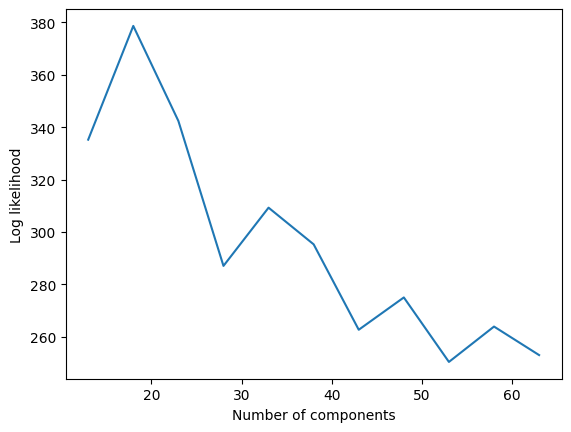

In [46]:
fig, ax = plt.subplots()
ax.plot(K_max, ll)
ax.set_xlabel('Number of components')
ax.set_ylabel('Log likelihood')

## Dictionary learning seperated between sources and target

In [50]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

In [51]:
criterion = JointWassersteinDistance()

In [52]:
dictionary_sources = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

In [54]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [82]:
names_sources = [f'domain {i}' for i in range(6)]

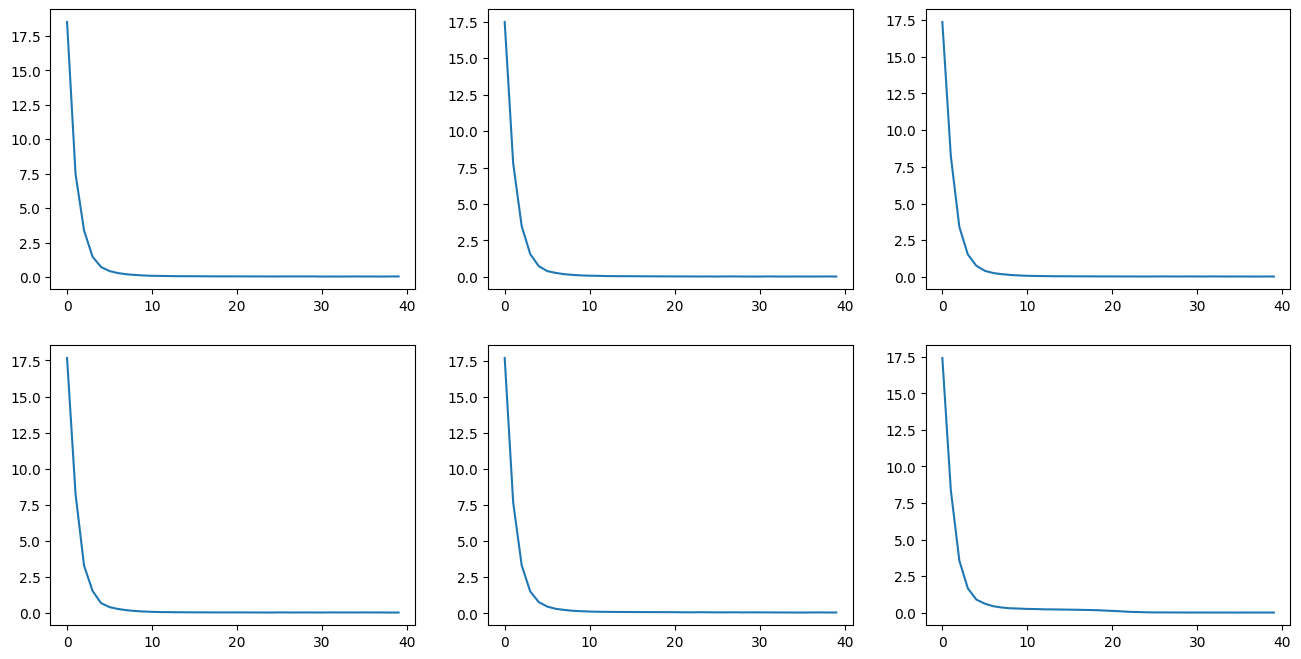

In [80]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, d in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][d])

In [99]:
dictionary_sources.history['weights']

[tensor([[0.3336, 0.3330, 0.3334],
         [0.3326, 0.3334, 0.3340],
         [0.3347, 0.3336, 0.3317],
         [0.3363, 0.3313, 0.3324],
         [0.3343, 0.3320, 0.3337],
         [0.3361, 0.3317, 0.3322]]),
 tensor([[0.3344, 0.3342, 0.3314],
         [0.3319, 0.3329, 0.3353],
         [0.3345, 0.3354, 0.3301],
         [0.3359, 0.3309, 0.3333],
         [0.3353, 0.3304, 0.3343],
         [0.3384, 0.3313, 0.3303]]),
 tensor([[0.3354, 0.3341, 0.3305],
         [0.3332, 0.3273, 0.3395],
         [0.3315, 0.3374, 0.3311],
         [0.3316, 0.3396, 0.3288],
         [0.3333, 0.3323, 0.3344],
         [0.3369, 0.3335, 0.3296]]),
 tensor([[0.3383, 0.3345, 0.3272],
         [0.3323, 0.3241, 0.3436],
         [0.3267, 0.3426, 0.3307],
         [0.3296, 0.3461, 0.3243],
         [0.3296, 0.3349, 0.3356],
         [0.3353, 0.3338, 0.3309]]),
 tensor([[0.3402, 0.3356, 0.3242],
         [0.3315, 0.3239, 0.3446],
         [0.3236, 0.3458, 0.3305],
         [0.3303, 0.3480, 0.3218],
         [0.

In [100]:
torch.stack(dictionary_sources.history['weights']).shape

torch.Size([40, 6, 3])

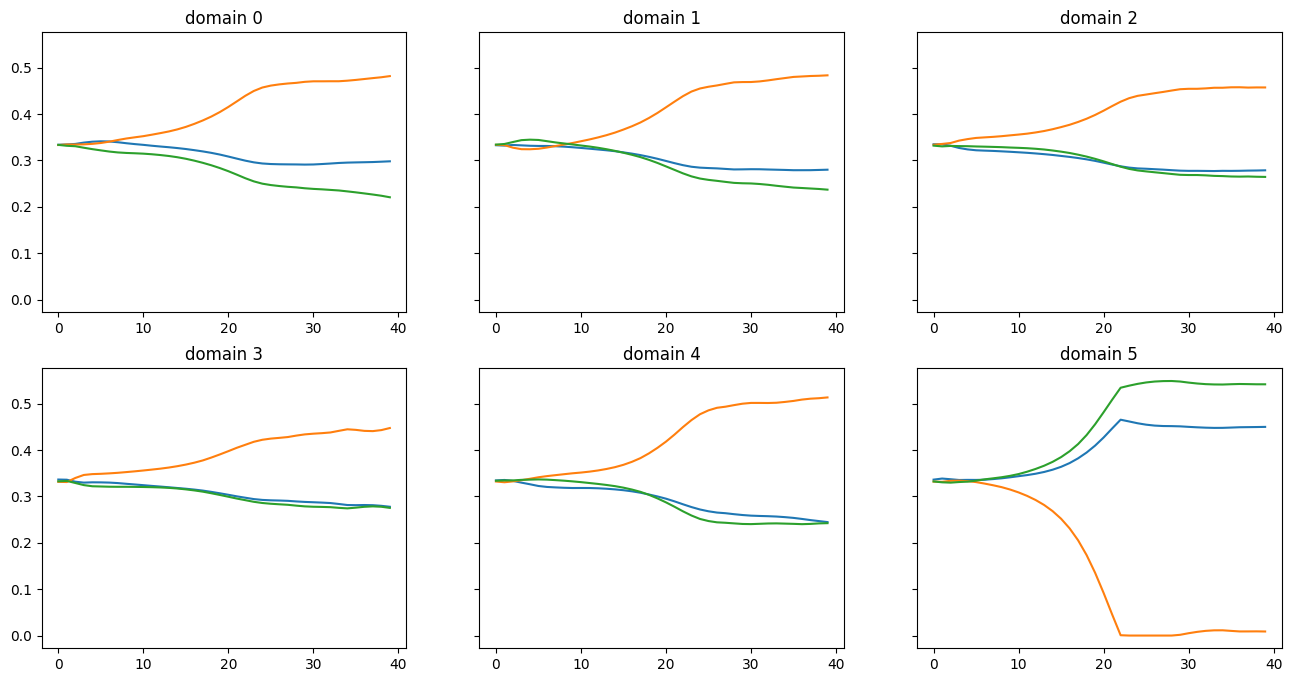

In [83]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [56]:
dictionary_target = LabeledDictionary(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

In [84]:
target_name = 'Domain 7'

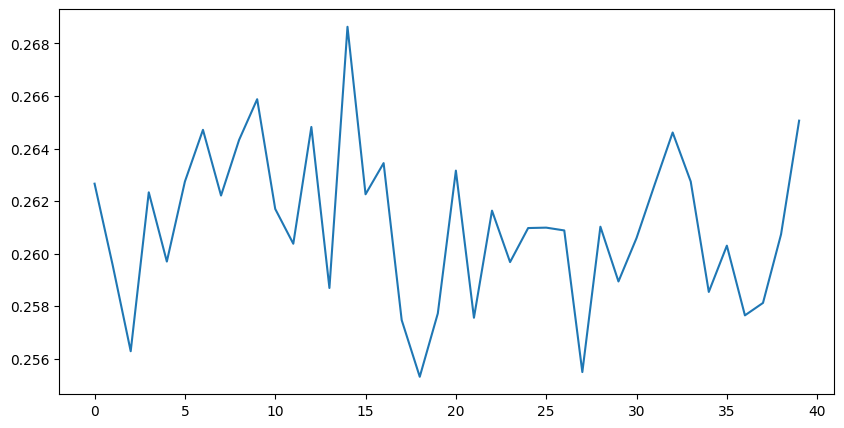

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

In [101]:
torch.stack(dictionary_target.history['weights']).shape

torch.Size([40, 1, 3])

Text(0.5, 1.0, 'doamin 7')

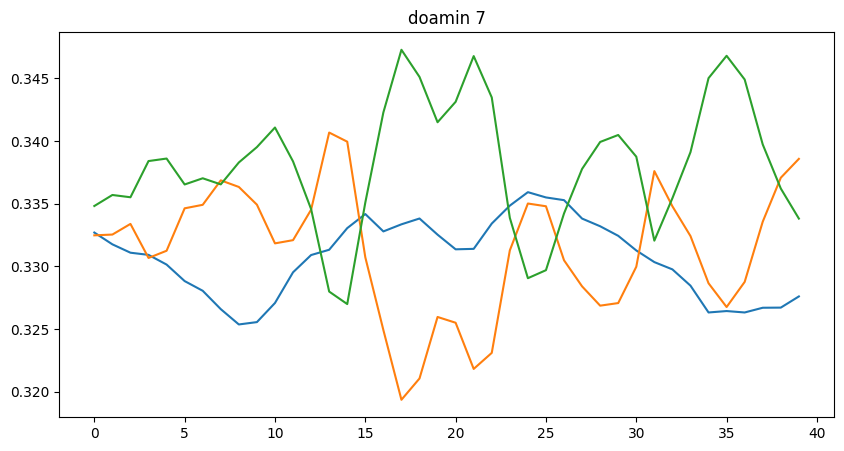

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, 0, :])
ax.set_title(target_name)

In [58]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.3276, 0.3386, 0.3338])


In [59]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [63]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


DaDiL-E

In [77]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.328000009059906 got 0.5615384615384615
Atom 1 w/ weight 0.33899998664855957 got 0.33076923076923076
Atom 2 w/ weight 0.33399999141693115 got 0.6692307692307692
0.6076923076923076


DaDiL-R

In [73]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5923076923076923


## Classic Dictionary Learning

In [15]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [21]:
criterion = JointWassersteinDistance()

In [17]:
dictionary = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

In [ ]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

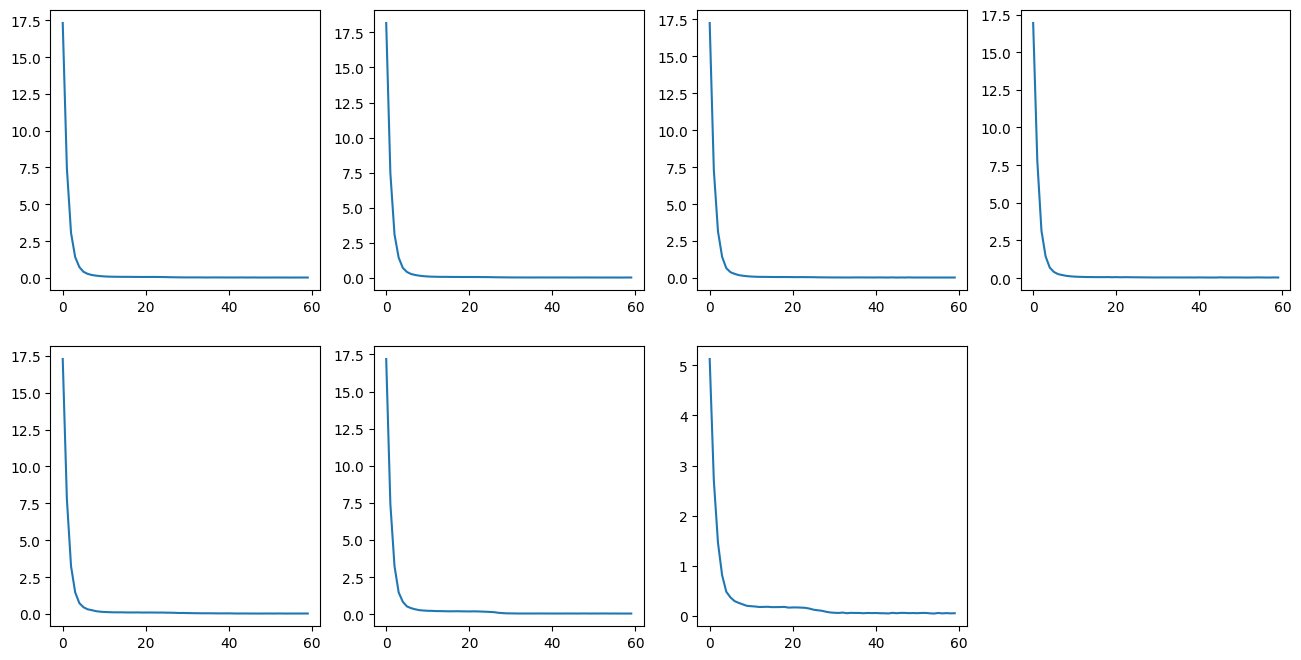

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, d in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][d])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0673781655728817, 0.7154823370277882)

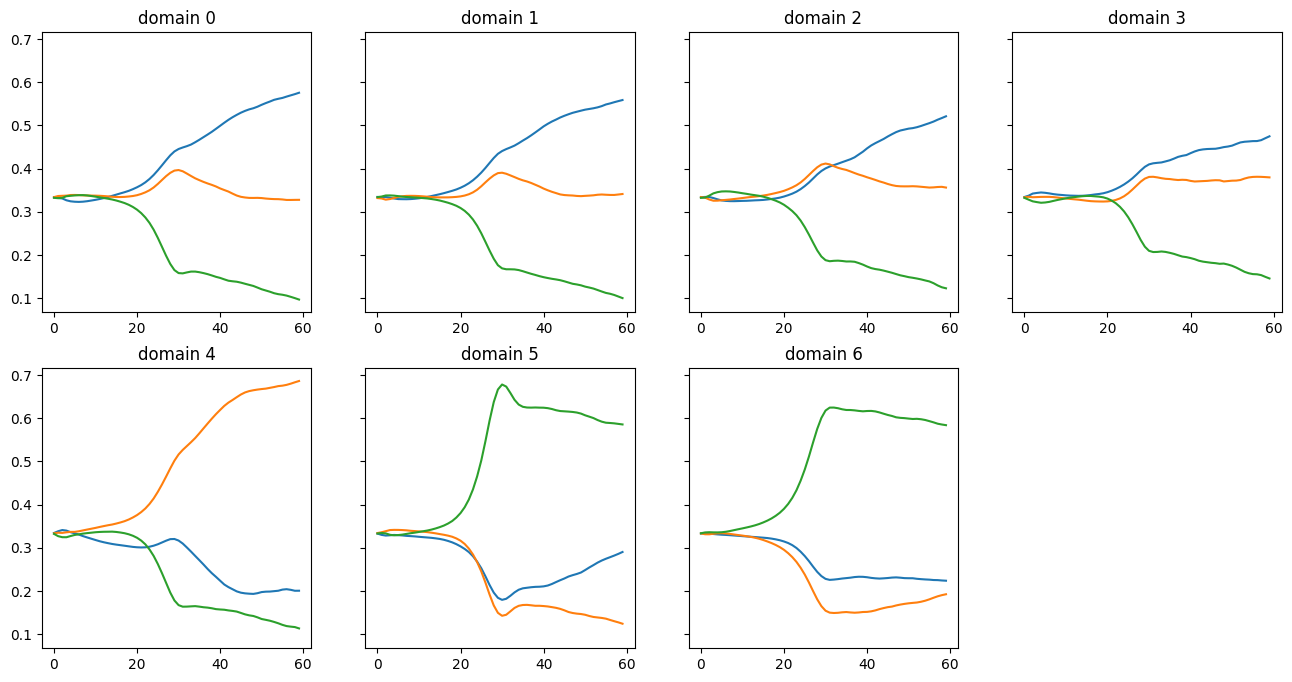

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [ ]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2238, 0.1924, 0.5838])


In [ ]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


In [ ]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.328000009059906 got 0.5615384615384615
Atom 1 w/ weight 0.33899998664855957 got 0.33076923076923076
Atom 2 w/ weight 0.33399999141693115 got 0.6692307692307692
0.6076923076923076


In [ ]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5923076923076923
